# Real estate: Price predictions  
*Created by: 
Anna Sukhareva, data scientist  
Antwerpen, Belgium  
Date: October 13, 2019  
Contacts: anna@linefeed.be*
***

## Table of Contents
Stage 1 : Business Understanding    
Stage 2 : Analytic Approach  
Stage 3 : Data Requirements  
Stage 4 : Data Collection  
Stage 5 : Data Understanding and Preparation  
Stage 6 : Modeling  
Stage 7 : Evaluation  
Summary  
***
### Stage 1 : Business Understanding  
**Problem:**  
Many real estate firms have long made decisions based on a combination of intuition and traditional, retrospective data. As a result, investors kept making the same mistakes. While the element of risk cannot be completely eliminated, businesses are looking for accurate predictive models to predict pricing based on sets of features.  
**Question:**  
Can we automatically predict house price? 

### Stage 2 : Analytic Approach  
A linear regression model with multiple variables will be built.

### Stage 3 : Data Requirements  
Data content: real estate market data.
Formats CSV format.
Sources : Market overview, extra information from open sources.
### Stage 4 : Data Collection   
Data were collected from [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices)

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#machinelearning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#read the file 
#df = pd.read_csv('../input/california-housing-prices/housing.csv')
df = pd.read_csv('housing.csv')

### Stage 5 : Data Understanding and Preparation

#### Dealing with outliers

In [2]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category') #207 missed in 'total_bedrooms'
df.dropna(axis=0, inplace=True)
cols= ['population', 'total_rooms', 'total_bedrooms', 'households', 'housing_median_age']
df[cols] = df[cols].applymap(np.int64)

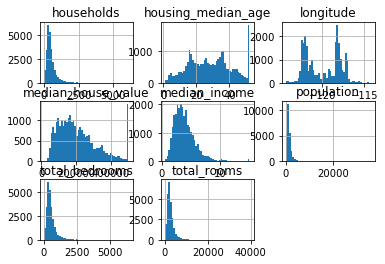

In [3]:
df.hist(bins=50)
plt.show() 

There are some outliers in 'population', 'total_bedrooms'. Let's work it out:

In [4]:
df = df[df.population < 6000]
df = df[df.total_bedrooms < 2000]

Next step: to convert ocean_proximity to dummie variables:

In [5]:
df = pd.get_dummies(data=df, columns=['ocean_proximity'], drop_first = False)
df.columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

And a visualization: 

In [ ]:
#df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=df['population']/100, label='diameter = population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
#plt.ylabel("Latitude", fontsize=14)
#plt.xlabel("Longitude", fontsize=14)
#plt.legend() 
#plt.show()

We can see, that the most expencive houses are near with ocean and on the islands.

#### Correlation discovering

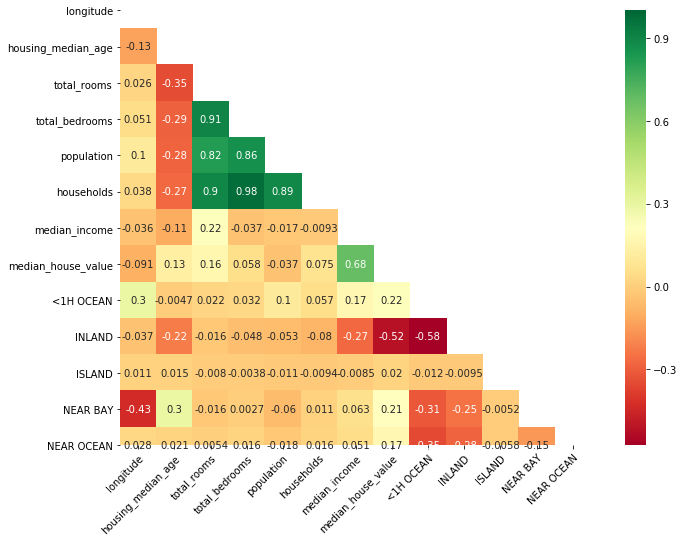

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), square=True, cmap='RdYlGn', annot=True, mask=mask)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Checking the correlation and find area with correlation higher then 90%:

In [8]:
CorrKoef = df.corr()
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.9]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print("%s-->%s: r^2=%f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

total_rooms-->total_bedrooms: r^2=0.906118


As a result, we see that total_rooms has a strong correlation with total_bedrooms, r^2=0.903767.

In [9]:
df = df.drop(['total_bedrooms'], axis=1)

### Stage 6 : Modeling

In [10]:
X = df.drop(['median_house_value', 'housing_median_age', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'] , axis=1).values
y = df['median_house_value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (17803, 6)
X_test : (7631, 6)
y_train : (17803,)
y_test : (7631,)


In [11]:
LinearRegression = LinearRegression()
Ridge = Ridge(alpha = 0.3, normalize=True)
Lasso = Lasso(alpha=0.6, normalize=True)
RandomForest = RandomForestRegressor(n_estimators=100)

def calculate_R2(model, model_name):
    model.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    R2 = model.score(X_test, y_test).round(4)
    print(model_name, 'R^2: {}' .format(R2))
    return R2

LinearRegression_R2 = calculate_R2(LinearRegression, 'Linear Regression')
Ridge_R2 = calculate_R2(Ridge, 'Ridge Regression')
Lasso_R2 = calculate_R2(Lasso, 'Lasso Regression')
RandomForest_R2 = calculate_R2(RandomForest, 'Random Forest')

 
def calculate_RMSE(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    print(model_name, "RMSE: {}".format(RMSE))
    return RMSE
    
LinearRegression_RMSE = calculate_RMSE(LinearRegression, 'Linear Regression')
Ridge_RMSE = calculate_RMSE(Ridge, 'Ridge Regression')
Lasso_RMSE = calculate_RMSE(Lasso, 'Lasso Regression')
RandomForest_RMSE = calculate_RMSE(RandomForest, 'Random Forest')

Linear Regression R^2: 0.6528
Ridge Regression R^2: 0.5234
Lasso Regression R^2: 0.6526
Random Forest R^2: 0.8889
Linear Regression RMSE: 70293.49
Ridge Regression RMSE: 82360.87
Lasso Regression RMSE: 70316.27
Random Forest RMSE: 39802.99


In [12]:
df_R2_RMSE = pd.DataFrame(
    {
        'Model':['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest'], 
        'R^2':[LinearRegression_R2, Ridge_R2, Lasso_R2, RandomForest_R2], 
        'RMSE':[LinearRegression_RMSE, Ridge_RMSE, Lasso_RMSE,RandomForest_RMSE]
    }
)
print(df_R2_RMSE)

               Model     R^2      RMSE
0  Linear Regression  0.6528  70293.49
1   Ridge Regression  0.5234  82360.87
2   Lasso Regression  0.6526  70316.27
3      Random Forest  0.8889  39802.99


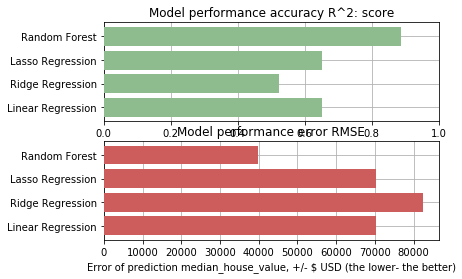

In [13]:
# #result visualization
x = range(df_R2_RMSE.shape[0])
plt.subplot(2,1,1)
R2 = plt.barh(x, df_R2_RMSE['R^2'], color=('darkseagreen'), zorder=3)
plt.xlabel('Score, 1 = 100% (the higher - the better)')
plt.yticks(x, df_R2_RMSE['Model'])
plt.title('Model performance accuracy R^2: score')
plt.grid(zorder=0)
plt.xlim(0, 1)
plt.subplot(2,1,2)
RMSE =plt.barh(x, df_R2_RMSE['RMSE'], color=('indianred'), zorder=3)
plt.xlabel('Error of prediction median_house_value, +/- $ USD (the lower- the better)')
plt.yticks(x, df_R2_RMSE['Model'])
plt.title('Model performance error RMSE')
plt.grid(zorder=0)
plt.show()

As we can see, the best result is RandomForest:
* score accuracy R^2 = 0.83, 
* RMSE = 47719. 

Let's check model performace on train & test sets:

In [14]:
print('Random Forest R^2, trainig set score: {}'.format(RandomForest.score(X_train,y_train).round(2))) 
print('Random orest  R^2, test set score: {}' .format(RandomForest.score(X_test, y_test).round(2)))

Random Forest R^2, trainig set score: 0.98
Random orest  R^2, test set score: 0.89


### Stage 7 : Evaluation

Let's find the most important features: 

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_)
print(df.columns)
a = [1.59355511e-01, 1.58931937e-01, 1.66395796e-01, 1.66248286e-01, 1.64999606e-01, 1.78599421e-01, 1.55412018e-03, 1.17474724e-03, 9.90116605e-05, 1.16597876e-03, 1.47558530e-03]
b = ['longitude', 'latitude', 'total_rooms', 'population', 'households', 'median_income', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
c = pd.DataFrame(a, index = b, columns=['value'])
print(c.sort_values(by=['value'], ascending=False))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


As the result, we need to drop '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN' and try again. As I did it already on machine, the parameters in the STEP 5 and score are already tunned.

### SUMMARY

* Best result: regression model with Random Forest classifier
* Accuracy score R^2: 0.8295 or 83%
* RMSE: 47720.54